In [1]:
REDUCT_URL = "http://192.168.178.94/cos-robotics-model-reductstore"
API_TOKEN = "reductstore"
BUCKET = "autonomous_mobile_robot"

IMAGE_ENTRIES = [
    "camera_image_color_compressed",
    "camera_image_raw_compressed",
    "flir_boson_image_raw_compressed",
    "rsense_color_image_raw_compressed",
]

POINTCLOUD_ENTRIES = [
    "ground_cloud",
    "os_node_segmented_point_cloud_no_destagger",
    "tree_cloud",
]

MCAP_ENTRY = "lightweight_telemetry"

In [2]:
from reduct import Client

async with Client(REDUCT_URL, api_token=API_TOKEN) as client:
    bucket = await client.create_bucket(BUCKET, exist_ok=True)
    entries = await bucket.get_entry_list()

print(f"Using bucket: {bucket.name} with {len(entries)} entries:")
for entry in entries:
    print(f" - {entry.name}")


Using bucket: autonomous_mobile_robot with 8 entries:
 - camera_image_color_compressed
 - camera_image_raw_compressed
 - flir_boson_image_raw_compressed
 - ground_cloud
 - lightweight_telemetry
 - os_node_segmented_point_cloud_no_destagger
 - rsense_color_image_raw_compressed
 - tree_cloud


In [3]:
ENTRY = IMAGE_ENTRIES[0]

from reduct import Client

peek = []
async with Client(REDUCT_URL, api_token=API_TOKEN) as client:
    bucket = await client.create_bucket(BUCKET, exist_ok=True)
    i = 0
    async for rec in bucket.query(ENTRY):
        peek.append((rec.timestamp, rec.content_type, dict(rec.labels)))
        i += 1
        if i >= 3:
            break

peek

200


[(1709997000358021,
  'image/jpeg',
  {'compression': 'jpeg',
   'serialization': 'cdr',
   'source_encoding': 'bgr8',
   'topic': '/camera/image_color/compressed_restamped',
   'type': 'sensor_msgs/msg/CompressedImage'}),
 (1709997000502773,
  'image/jpeg',
  {'compression': 'jpeg',
   'serialization': 'cdr',
   'source_encoding': 'bgr8',
   'topic': '/camera/image_color/compressed_restamped',
   'type': 'sensor_msgs/msg/CompressedImage'}),
 (1709997000646407,
  'image/jpeg',
  {'compression': 'jpeg',
   'serialization': 'cdr',
   'source_encoding': 'bgr8',
   'topic': '/camera/image_color/compressed_restamped',
   'type': 'sensor_msgs/msg/CompressedImage'})]

200


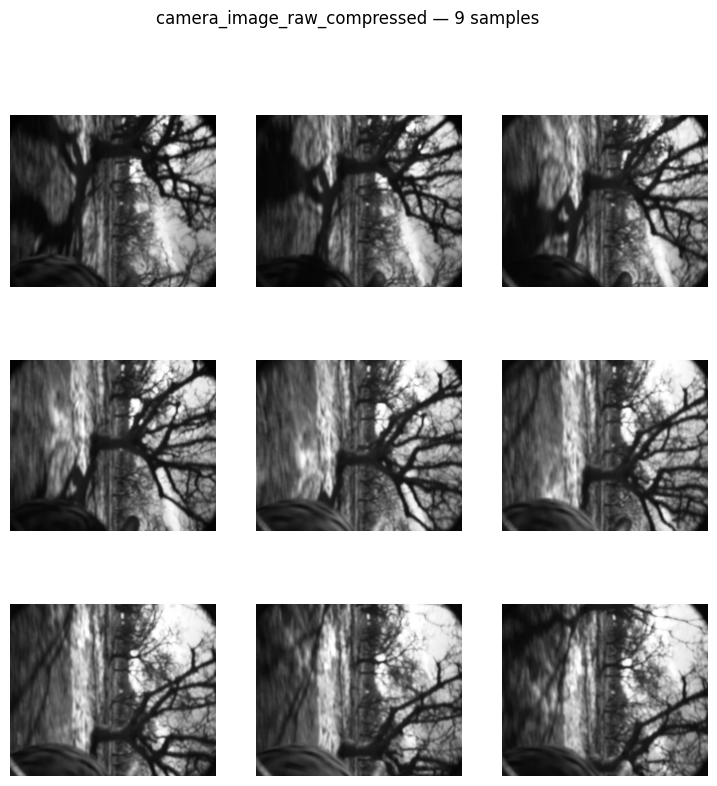

In [4]:
ENTRY = "camera_image_raw_compressed"

import io, math, numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from reduct import Client

images = []
async with Client(REDUCT_URL, api_token=API_TOKEN) as client:
    bucket = await client.create_bucket(BUCKET, exist_ok=True)
    async for rec in bucket.query(ENTRY):
        if rec.content_type and rec.content_type.startswith("image/"):
            b = await rec.read_all()
            try:
                images.append(Image.open(io.BytesIO(b)).convert("RGB"))
            except Exception:
                pass
        if len(images) >= 9:
            break

n = len(images)
if n:
    cols = math.ceil(math.sqrt(n))
    rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = np.array(axes).reshape(rows, cols)
    for i, ax in enumerate(axes.flat):
        ax.axis("off")
        if i < n:
            ax.imshow(images[i])
    fig.suptitle(f"{ENTRY} — {n} samples")
    plt.show()
else:
    print("No images found.")


200


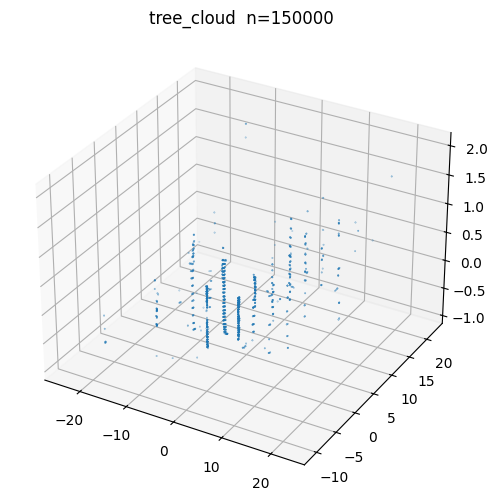

In [5]:
ENTRY = "tree_cloud"

import numpy as np
import matplotlib.pyplot as plt
from reduct import Client

first_rec = None
async with Client(REDUCT_URL, api_token=API_TOKEN) as client:
    bucket = await client.create_bucket(BUCKET, exist_ok=True)
    async for rec in bucket.query(ENTRY):
        first_rec = rec
        break

if first_rec is None:
    print("No pointcloud records found.")
else:
    labels = first_rec.labels
    payload = await first_rec.read_all()

    point_step = int(labels.get("point_step", "0"))
    height = int(labels.get("height", "0"))
    width = int(labels.get("width", "0"))

    if point_step < 12:
        print("point_step too small to contain XYZ.")
    else:
        npts = len(payload) // point_step
        arr = np.frombuffer(payload, dtype=np.uint8).reshape(npts, point_step)
        xyz = arr[:, :12].view(np.float32).reshape(npts, 3)
        if height and width and height*width <= len(xyz):
            xyz = xyz[: height*width]
        if len(xyz) > 150_000:
            idx = np.random.default_rng(0).choice(len(xyz), size=150_000, replace=False)
            xyz = xyz[idx]

        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], s=0.1)
        ax.set_title(f"{ENTRY}  n={len(xyz)}")
        plt.show()
